# NN Feature

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras.models import Model
from sklearn.preprocessing import StandardScaler


2022-10-25 02:18:11.288931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 02:18:11.289046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 397)]             0         
_________________________________________________________________
dense (Dense)                (None, 198)               78804     
_________________________________________________________________
dense_1 (Dense)              (None, 99)                19701     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100       
Total params: 98,605
Trainable params: 98,605
Non-trainable params: 0
_________________________________________________________________


2022-10-25 02:18:11.695575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 02:18:11.854418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/1000
599/599 [==============================] - ETA: 0s - loss: 63.5148

2022-10-25 02:18:16.787837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


599/599 [==============================] - 5s 9ms/step - loss: 63.5148 - val_loss: 20.0316
Epoch 2/1000
599/599 [==============================] - 5s 9ms/step - loss: 21.0846 - val_loss: 12.0237
Epoch 3/1000
599/599 [==============================] - 5s 8ms/step - loss: 11.1704 - val_loss: 10.2073
Epoch 4/1000
599/599 [==============================] - 5s 8ms/step - loss: 6.4028 - val_loss: 11.9587
Epoch 5/1000
599/599 [==============================] - 5s 8ms/step - loss: 5.4674 - val_loss: 37.6797
Epoch 6/1000
599/599 [==============================] - 5s 8ms/step - loss: 5.5764 - val_loss: 7.5767
Epoch 7/1000
599/599 [==============================] - 5s 8ms/step - loss: 2.3232 - val_loss: 1.5650
Epoch 8/1000
599/599 [==============================] - 5s 9ms/step - loss: 1.7019 - val_loss: 2.7072
Epoch 9/1000
599/599 [==============================] - 5s 9ms/step - loss: 2.2421 - val_loss: 1.4931
Epoch 10/1000
599/599 [==============================] - 5s 9ms/step - loss: 2.1492 - v

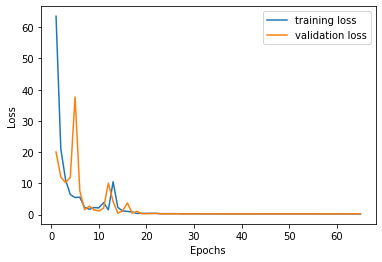

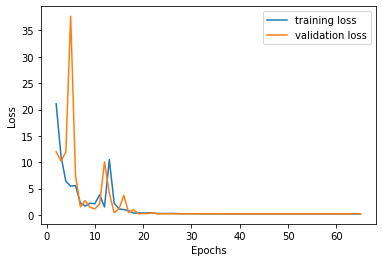

2022-10-25 02:23:32.877550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


RMSPE : 0.22120047123381695


In [2]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true-y_pred)/y_true)))

X_train = pd.read_pickle('./397/X_train_tf.pkl').astype(float)
y_train = pd.read_pickle('./397/y_train_tf.pkl').astype(float)
X_val = pd.read_pickle('./397/X_val_tf.pkl').astype(float)
y_val = pd.read_pickle('./397/y_val_tf.pkl').astype(float)
X_test = pd.read_pickle('./397/X_test_tf.pkl').astype(float)
y_test = pd.read_pickle('./397/y_test_tf.pkl').astype(float)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

inputs= tf.keras.Input(
        shape=(X_train.shape[1],)
    )
hidden1=tf.keras.layers.Dense(
        units=int(np.round(X_train.shape[1]/2, 0)),
        kernel_initializer='he_uniform',
        activation='LeakyReLU'
    )(inputs)
hidden2=tf.keras.layers.Dense(
        units=int(np.round(X_train.shape[1]/4, 0)),
        kernel_initializer='he_uniform',
        activation='LeakyReLU'
    )(hidden1)
    
outputs=tf.keras.layers.Dense(
        units=1,
)(hidden2)

model = Model(inputs, outputs)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=rmspe)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_delta=1e-5, min_lr=1e-5, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=11, restore_best_weights=True, verbose=1)
callback_list = [rlr, es]
history = model.fit(X_train, y_train,
                    batch_size=500, epochs=1000, verbose=1,
                    validation_data=(X_val, y_val), callbacks=callback_list
)

print(pd.DataFrame(history.history))
epochs=np.arange(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'], label='training loss')
plt.plot(epochs, history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs=np.arange(2, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'][1:], label='training loss')
plt.plot(epochs, history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

a = np.array([]).reshape(0, 1)

for x in range (1, 42):
    length = int((X_test.shape[0] / 41))
    test = X_test[length*(x-1):length*(x)]
    
    y_hat = model.predict(test)
    a = np.append(a, y_hat)

result_rmspe = np.sqrt(np.mean(np.square(((a - y_test) / y_test)), axis=0))
print('RMSPE :', result_rmspe)
    

# Base Feature

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 335)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 168)               56448     
_________________________________________________________________
dense_4 (Dense)              (None, 84)                14196     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 85        
Total params: 70,729
Trainable params: 70,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 10/599 [..............................] - ETA: 3s - loss: 421.2015  

2022-10-25 02:23:39.495964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


598/599 [============================>.] - ETA: 0s - loss: 57.6953

2022-10-25 02:23:42.966538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


599/599 [==============================] - 4s 6ms/step - loss: 57.6894 - val_loss: 26.2735
Epoch 2/1000
599/599 [==============================] - 4s 6ms/step - loss: 20.0381 - val_loss: 10.7381
Epoch 3/1000
599/599 [==============================] - 3s 6ms/step - loss: 9.6133 - val_loss: 7.4227
Epoch 4/1000
599/599 [==============================] - 3s 6ms/step - loss: 6.2952 - val_loss: 5.3667
Epoch 5/1000
599/599 [==============================] - 4s 6ms/step - loss: 4.6377 - val_loss: 4.2817
Epoch 6/1000
599/599 [==============================] - 4s 6ms/step - loss: 4.0275 - val_loss: 2.8599
Epoch 7/1000
599/599 [==============================] - 3s 6ms/step - loss: 3.7057 - val_loss: 2.4433
Epoch 8/1000
599/599 [==============================] - 3s 6ms/step - loss: 6.2298 - val_loss: 2.3900
Epoch 9/1000
599/599 [==============================] - 3s 6ms/step - loss: 3.6891 - val_loss: 2.8719
Epoch 10/1000
599/599 [==============================] - 3s 6ms/step - loss: 2.4763 - val_l

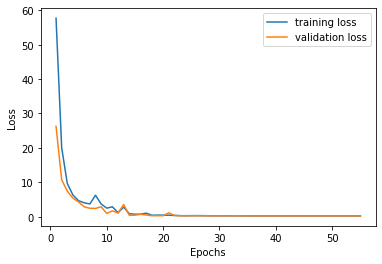

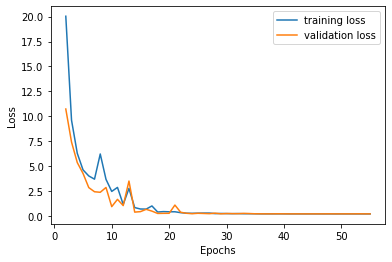

2022-10-25 02:26:58.357759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


RMSPE : 0.24309704699707682


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras.models import Model
from sklearn.preprocessing import StandardScaler

def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true-y_pred)/y_true)))

X_train = pd.read_pickle('./397/X_train_base.pkl').astype(float)
y_train = pd.read_pickle('./397/y_train_base.pkl').astype(float)
X_val = pd.read_pickle('./397/X_val_base.pkl').astype(float)
y_val = pd.read_pickle('./397/y_val_base.pkl').astype(float)
X_test = pd.read_pickle('./397/X_test_base.pkl').astype(float)
y_test = pd.read_pickle('./397/y_test_base.pkl').astype(float)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
X_train.shape[1]

inputs= tf.keras.Input(
        shape=(X_train.shape[1],)
    )
hidden1=tf.keras.layers.Dense(
        units=int(np.round(X_train.shape[1]/2, 0)),
        kernel_initializer='he_uniform',
        activation='LeakyReLU'
    )(inputs)
hidden2=tf.keras.layers.Dense(
        units=int(np.round(X_train.shape[1]/4, 0)),
        kernel_initializer='he_uniform',
        activation='LeakyReLU'
    )(hidden1)
outputs=tf.keras.layers.Dense(
        units=1,
)(hidden2)

model = Model(inputs, outputs)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=rmspe)
              
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_delta=1e-5, min_lr=1e-5, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=11, restore_best_weights=True, verbose=1)
callback_list = [rlr, es]
history = model.fit(X_train, y_train,
                    batch_size=500, epochs=1000, verbose=1,
                    validation_data=(X_val, y_val), callbacks=callback_list
)
pd.DataFrame(history.history)
epochs=np.arange(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'], label='training loss')
plt.plot(epochs, history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs=np.arange(2, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'][1:], label='training loss')
plt.plot(epochs, history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

a = np.array([]).reshape(0, 1)

for x in range (1, 42):
    length = int((X_test.shape[0] / 41))
    test = X_test[length*(x-1):length*(x)]
    
    y_hat = model.predict(test)
    #print(y_hat)
    a = np.append(a, y_hat)

result_rmspe = np.sqrt(np.mean(np.square(((a - y_test) / y_test)), axis=0))
print('RMSPE :', result_rmspe)
    